# **Calculation of $K_p$ using thermochemistry and simulations: the $\mathrm{N}_{2}\mathrm{O}_{4} \rightleftharpoons 2 \mathrm{NO}_{2}$ reaction![pyscf-logo.png](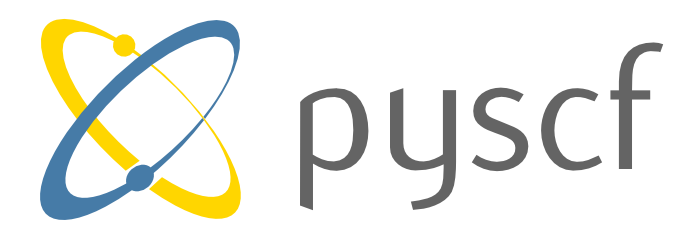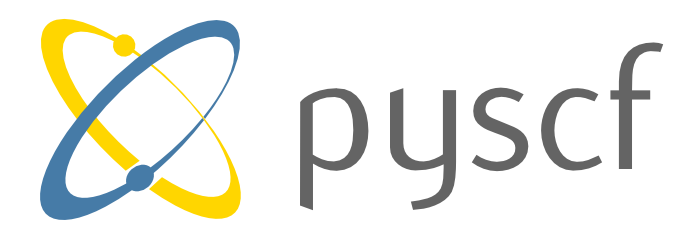)**

In [ ]:
#@title Installation of packages. It takes $\approx$ 1 min
%%capture
! sudo apt update
! sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended
!pip install --prefer-binary pyscf
!pip install pyscf[geomopt]
!pip install dftd3 dftd4
!pip install pubchempy chempy


In [ ]:
#@title Defining constants and the function to determine $\mu^0$ using the ideal-gas, RR-HO approximation
# Defining some constants
m_u    = 1.66053886e-27      # atomic mass constant in kg
h      = 6.6260693e-34       # Planck's constant in J*s
k_B    = 1.3806505e-23       # Boltzmann's constant in J/K
c      = 2.99792558e8        # Speed of light in m/s
bar2Pa = 1e5                 # 1 bar to N/m**2
Pa2bar = 1e-5                # 1 Pa=N/m**2 to bar
p0     = 1                   # standard pressure in bar
R      = 8.314472e-3         # Gas constant in kJ/(K mol)
H2kcal = 627.509             # Hartree to kcal/mol
H2kJ   = 2625.5              # Hartree to kJ/mol

import numpy as np

def G_m_0(temp,m,A,B,C,lin_A,nat_A,sigma,spin,*freq):
  import math
  q_t = (2*math.pi*m*m_u*k_B*temp/h/h)**1.5*k_B*temp/bar2Pa
  St = R * np.log(q_t)
  Ut = 1.5 * R * temp
  q_r = 1 ; q_v = 1 ; Sr = 0 ; Sv = 0 ; Ur = 0 ; Uv = 0
  if nat_A > 1:
    rA  = h * c * 100 * A / k_B
    rB  = h * c * 100 * B / k_B
    rC  = h * c * 100 * C / k_B
    if lin_A == 0:
      q_r = 1 / sigma * math.sqrt(math.pi)*(temp**1.5/math.sqrt(rA*rB*rC))
      Sr = R * (1.5 + np.log(q_r))
      Ur = 1.5 * R * temp
    else:
      if rA == 0:
        rl = math.sqrt(rB*rC)
      elif rB == 0:
        rl = math.sqrt(rA*rC)
      else:
        rl = math.sqrt(rA*rB)
      q_r = 1 / sigma * temp / rl
      Sr = R * (1 + np.log(q_r))
      Ur = R * temp
    for ele in freq:
      rv   = h * c * 100 * float(ele) / k_B
      q_v *= 1 / (1 - np.exp(-rv/temp))
      Sv  += R * (rv / temp / (np.exp(rv/temp) - 1) - np.log(1 - np.exp(-rv/temp)) )
      Uv += R * rv / (np.exp(rv/temp) - 1)
  q_e = spin +1
  q = q_t * q_r * q_v * q_e
  return - R * temp * np.log(q)


# We now focus on the $\mathrm{N}_{2}\mathrm{O}_{4} \rightleftharpoons 2 \mathrm{NO}_{2}$ reaction

In [ ]:
#@title Using Chempy to handle the $\mathrm{N}_{2}\mathrm{O}_{4} \rightleftharpoons 2 \mathrm{NO}_{2}$ reaction
from operator import mul
from functools import reduce
from itertools import product
import chempy
from chempy import Substance
from chempy.chemistry import Species, Equilibrium, Reaction
from chempy.equilibria import EqSystem, NumSysLog, NumSysLin
from chempy import balance_stoichiometry
import numpy as np
import sympy as sp
sp.init_printing()
import matplotlib.pyplot as plt

temp = 298.15
reactf='N2O4'
prodf='NO2'
spin=[]
react = Substance.from_formula(reactf)
prod  = Substance.from_formula(prodf)
#print("Reactant:",react.unicode_name)
#print("Product :",prod.unicode_name)
spin_react=spin_prod=0
for ele in react.composition.keys(): spin_react += ele * react.composition[ele]
spin.append(spin_react % 2)
for ele in prod.composition.keys(): spin_prod += ele * prod.composition[ele]
spin.append(spin_prod % 2)
print("Spin list:",spin)

reac, pr = balance_stoichiometry({reactf},{prodf})

equilibrium = Equilibrium(reac, pr)

keys = [reactf,prodf]

subst = {k: Substance.from_formula(k) for k in keys}
r_latex=equilibrium.latex(subst)
r_unicode=equilibrium.unicode(subst)
print(r_unicode)


In [ ]:
#@title Retrieving structures of reactant and product from PubChem https://pubchem.ncbi.nlm.nih.gov/
import pubchempy as pcp

keys1=['N2O4', 'nitrogen dioxide']
#print(keys)
#print(keys1)
natom = []
for k,ele in enumerate(keys1):
  molA = ele
  #molA = input('Name of your substance: ')
  queryA0 = pcp.get_compounds(molA,'name')
  queryA = pcp.get_compounds(molA,'name',record_type='3d')
  if(len(queryA)==0): queryA = queryA0
  cid_A = pcp.get_cids(molA)
  if len(cid_A) == 0: print('Molecule not found')
  else: print('CID of',Substance.from_formula(keys[k]).unicode_name,': ',cid_A)

  m = queryA[0]
  natom.append(len(m.atoms))
  f = open(keys[k]+'.xyz','w')
  if natom[k] > 1:
    f.write(str(natom[k])+'\n\n')
    for i,a in enumerate(m.atoms):
      if a.z is None: a.z = 0.0
      f.write(m.elements[i]+' '+str(a.x)+' '+str(a.y)+' '+str(a.z)+'\n')
  else:                            f.write(m.elements[0]+' 0. 0. 0.\n')
  f.close()

### Using [pyscf](https://pyscf.org) to optimize the structures at the PBE0-D4/6-31G level of theory

In [ ]:
#@title This takes a few minutes...
from pyscf import gto, scf
from pyscf.hessian import thermo
from pyscf.geomopt.geometric_solver import optimize
import dftd4.pyscf as disp4
import os

#os.environ['OMP_NUM_THREADS'] = "8"

e0 = []
A = []
B = []
C = []
lin = []
freq_info = []
mass = []
sigma = []
mol_eq = []

functional ='pbe0'
for k,ele in enumerate(keys):
  mol = gto.M(atom = ele+".xyz",spin=spin[k],basis='6-31g')
  if spin[k] == 0: mf = mol.RKS(xc=functional)
  else: mf = mol.UKS(xc=functional)
# optimization
  mol_eq.append(optimize(mf, maxsteps=100))

  if spin[k] == 0: mf = mol_eq[k].RKS(xc=functional).run()
  else: mf = mol_eq[k].UKS(xc=functional).run()

  hessian = mf.Hessian().kernel()

  freq_info.append(thermo.harmonic_analysis(mf.mol, hessian))
  thermo_info = thermo.thermo(mf, freq_info[k]['freq_au'], temp, 101325)
  mass.append(mol.atom_mass_list(isotope_avg=True))
  rot_info = thermo.rotation_const(mass[k],mol_eq[k].atom_coords())
  sigma.append(thermo.rotational_symmetry_number(mol_eq[k]))
  #print(thermo_info)

  A.append(rot_info[0] * 0.033357)
  B.append(rot_info[1] * 0.033357)
  C.append(rot_info[2] * 0.033357)
  if A[k] == B[k] and C[k] <= 0.001: lin.append(1)
  else: lin.append(0)

  d4 = disp4.DFTD4Dispersion(mol_eq[k],xc=functional)
  e0.append(thermo_info['E0'][0] + d4.kernel()[0] + thermo_info['ZPE'][0])


In [ ]:
#@title Computing $G_m^0$, i.e, $\mu^0$ from the electronic energy, the ZPE and the thermal contribution

gcorr = []
g = []

for k,ele in enumerate(keys):
  gcorr.append(G_m_0(temp,sum(mass[k]),A[k],B[k],C[k],lin[k],natom[k],sigma[k],spin[k],*freq_info[k]['freq_wavenumber']))
  g.append( e0[k] * H2kJ + gcorr[k] )
  print('Frequencies of',Substance.from_formula(ele).unicode_name,'in cm-1')
  print(freq_info[k]['freq_wavenumber'])
  print("")

deltaG = (2 * g[1] - g[0])
deltaE = (2 * e0[1] - e0[0]) * H2kJ

print('deltaG:',deltaG,'kJ/mol--> Should be around 4.7 kJ/mol')

# Results (D4 dispersion):
# b3lyp/3-21g      --> 17.12 kJ/mol
# b3lyp/6-31g*     --> 11.20 kJ/mol
# b3lyp/def2svp    --> 15.48 kJ/mol

# pbe0/3-21g       --> 22.31 kJ/mol
# pbe0/6-31g       -->  4.52 kJ/mol   *************

print('deltaE:',deltaE,'kJ/mol')
print(np.exp(-deltaG / R / 298.15))
print(np.exp(-4.7 / R / 298.15))
